# Evaluation

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [91]:
experiments = {
    0: "0_plain",
    1: "1_meta",
    101: "101_meta_only_elements",
    2: "2_meta_headings",
    201: "201_meta_headings_only_elements",
    3: "3_headings_formatting_structure",
    301: "301_headings_formatting_structure_only_elements",
    4: "4_text_formatting",
    401: "401_text_formatting_only_elements",
    5: "5_structure",
    501: "501_structure_only_elements",
    6: "6_all_elements_without_div",
    601: "601_all_elements_without_div_only_elements",
    7: "7_all_elements_with_div",
    701: "701_all_elements_with_div_only_elements",
    8: "8_divs",
    801: "801_divs_only_elements",
    9: "9_paragraph",
    901: "901_paragraph_only_elements",
    10: "10_paragraph_metadescription",
    1001: "1001_paragraph_metadescription_only_elements",
    11: "11_a_paragraph_metadescription",
    1101: "1101_a_paragraph_metadescription_only_elements",
    12: "12_a_paragraph_metadescription_headings",
    1201: "1201_a_paragraph_metadescription_headings_only_elements",
    13: "13_list",
    1301: "1301_list_only_elements"
}


N = 13
EXP = experiments[N]
TESTING = False
SUB_DIR = "further_experiments"

PATH = f"../results/{SUB_DIR}/{EXP}/"

if TESTING:
    PATH = f"../testresults/{EXP}/"
    
clfreport_svm = pd.read_csv(PATH + f"clfreport__{EXP}_svm.csv", index_col=0)
clfreport_xgb_tree = pd.read_csv(PATH + f"clfreport__{EXP}_xgb_tree.csv", index_col=0)

cm_svm = pd.read_csv(PATH + f"cm__{EXP}_svm.csv", index_col=0)
cm_xgb_tree = pd.read_csv(PATH + f"cm__{EXP}_xgb_tree.csv", index_col=0)

# normalize
cm_svm = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis]
cm_xgb_tree = cm_xgb_tree.astype('float') / cm_xgb_tree.sum(axis=1)[:, np.newaxis]

## CLF report

In [92]:
clfreport_svm.tail(3)

precision    recall  f1-score      support
accuracy       0.694441  0.694441  0.694441     0.694441
macro avg      0.724322  0.667132  0.689524  7573.000000
weighted avg   0.694821  0.694441  0.690022  7573.000000

In [65]:
clfreport_xgb_tree.tail(3)

precision    recall  f1-score      support
accuracy       0.526212  0.526212  0.526212     0.526212
macro avg      0.595854  0.464388  0.509502  7573.000000
weighted avg   0.547212  0.526212  0.516165  7573.000000

## Confusion Matrices

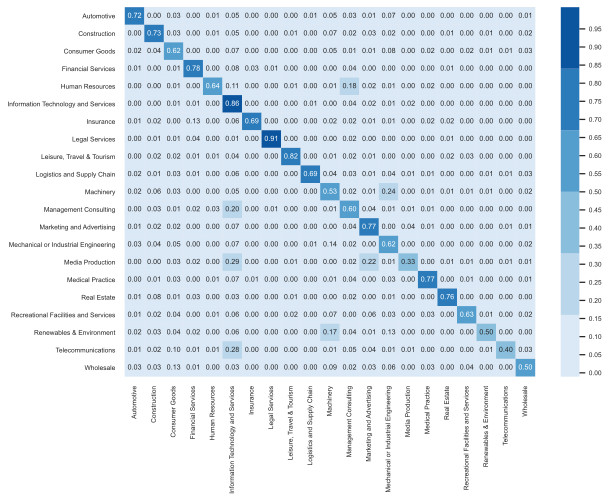

In [89]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(9, 7))
sns.set(font_scale=0.6)
sns.heatmap(cm_svm, 
            annot=True, 
            cmap=sns.color_palette("Blues"),
            vmin=-0.01,
            vmax=1.01,
            cbar_kws=dict(ticks=np.arange(0.0, 1.0, 0.05)),
            fmt='.2f')
plt.tight_layout()
#plt.savefig("cm.png", dpi=300, facecolor="white", transparent=False)
plt.show()

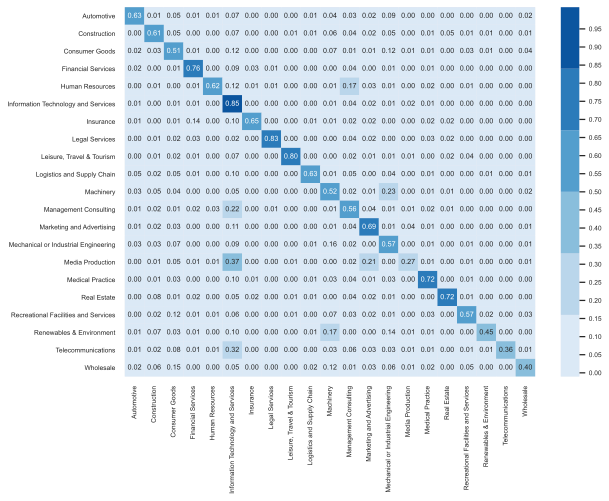

In [90]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(9, 7))
sns.set(font_scale=0.6)
sns.heatmap(cm_xgb_tree, 
            annot=True, 
            cmap=sns.color_palette("Blues"),
            vmin=-0.01,
            vmax=1.01,
            cbar_kws=dict(ticks=np.arange(0.0, 1.0, 0.05)),
            fmt='.2f')
plt.tight_layout()
#plt.savefig("cm.png", dpi=300, facecolor="white", transparent=False)
plt.show()

## Coefs & Feature Importance

In [93]:
%%time

def normalize(s):
    if len(s) > 1:
        if s[-2] == "." and s[-1].isdigit():
            return s[:-2]
        else:
            return s
    else:
        return s

# coefs, really big!
coefs_svm = pd.read_csv(PATH + f"coefs__{EXP}_svm.csv.zip", index_col=0)
new_columns = [normalize(col) for col in coefs_svm.columns]
coefs_svm.columns = new_columns
coefs_svm = coefs_svm.groupby(lambda x:x, axis=1).sum()


# feature importance
coefs_xgb_tree = pd.read_csv(PATH + f"fi__{EXP}_xgb_tree.csv", index_col=0)

CPU times: user 7min 5s, sys: 3.24 s, total: 7min 8s
Wall time: 7min 7s


In [94]:
# svm overall feature importance
svm_top = coefs_svm.abs().sum().sort_values(ascending=False).head(100)
svm_top[:3]

software    21.952159
it          17.830453
agentur     15.915855
dtype: float64

In [95]:
xgb_top = coefs_xgb_tree.sort_values(by="value", ascending=False).head(100)
xgb_top[:3]

value
feature                
arbeitsschutz  0.005480
sale           0.005055
voorraad       0.004203

### Analyzing

In [96]:
from collections import Counter
import json
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm


with open("../app/experiments.json") as f:
        experiments = json.load(f)
        
USECOLS = experiments[str(N)]["cols"][3:]
print(USECOLS)

train = pd.read_csv("../data/ctrain.csv", usecols=USECOLS, lineterminator="\n").fillna("")

['<li>']


In [97]:
### svm ###
counts_top = {}
svm_overall_word_count = {}

for col in tqdm(USECOLS):
    col_counts = {}
    
    col_str = " ".join(list(train[col]))
    tokens = word_tokenize(col_str.lower())
    svm_overall_word_count[col] = len(tokens)
    
    all_counts = dict(Counter(tokens).most_common())
    for k, _ in dict(svm_top).items(): 
        if k in all_counts:
            col_counts[k] = all_counts[k]
            
    counts_top[col] = col_counts
        
svm_counts_df = pd.DataFrame(counts_top).fillna(0)

In [98]:
### xgb ###
counts_top = {}
xgb_overall_word_count = {}

for col in tqdm(USECOLS):
    col_counts = {}
    
    col_str = " ".join(list(train[col]))
    tokens = word_tokenize(col_str.lower())
    xgb_overall_word_count[col] = len(tokens)
    
    all_counts = dict(Counter(tokens).most_common())
    for k, _ in xgb_top.to_dict()["value"].items(): 
        if k in all_counts:
            col_counts[k] = all_counts[k]
            
    counts_top[col] = col_counts
        
xgb_counts_df = pd.DataFrame(counts_top).fillna(0)

In [99]:
svm_counts_df[svm_counts_df != 0] = 1
print(svm_counts_df.sum())
print(svm_counts_df.sum().mean())
print()

xgb_counts_df[xgb_counts_df != 0] = 1
print(xgb_counts_df.sum())
print(xgb_counts_df.sum().mean())

<li>    100
dtype: int64
100.0

<li>    63
dtype: int64
63.0


In [100]:
all_svms[N] = svm_counts_df.sum()
all_xgbs[N] = xgb_counts_df.sum()

In [101]:
pd.DataFrame(all_svms).fillna("-")

9    10   11   12   13
<a>                   -    -  100   99    -
<h1>                  -    -    -   99    -
<h2>                  -    -    -   99    -
<h3>                  -    -    -   99    -
<h4>                  -    -    -   99    -
<h5>                  -    -    -   99    -
<li>                  -    -    -    -  100
<meta>_description    -  100  100  100    -
<p>                 100  100  100  100    -

In [102]:
pd.DataFrame(all_xgbs).fillna("-")

9   10  11  12  13
<a>                  -   -  89  92   -
<h1>                 -   -   -  84   -
<h2>                 -   -   -  87   -
<h3>                 -   -   -  88   -
<h4>                 -   -   -  84   -
<h5>                 -   -   -  81   -
<li>                 -   -   -   -  63
<meta>_description   -  84  88  90   -
<p>                 70  88  88  92   -

In [103]:
print(pd.DataFrame(all_svms).fillna("-").to_latex(index=True))

\begin{tabular}{llllll}
\toprule
{} &   9  &   10 &   11 &   12 &   13 \\
\midrule
<a>                &    - &    - &  100 &   99 &    - \\
<h1>               &    - &    - &    - &   99 &    - \\
<h2>               &    - &    - &    - &   99 &    - \\
<h3>               &    - &    - &    - &   99 &    - \\
<h4>               &    - &    - &    - &   99 &    - \\
<h5>               &    - &    - &    - &   99 &    - \\
<li>               &    - &    - &    - &    - &  100 \\
<meta>\_description &    - &  100 &  100 &  100 &    - \\
<p>                &  100 &  100 &  100 &  100 &    - \\
\bottomrule
\end{tabular}



In [373]:
print(pd.DataFrame(all_xgbs).fillna("-").to_latex(index=True))

\begin{tabular}{lllllllrl}
\toprule
{} &   1 &   2 &   3 &  4 &   5 &   6 &     7 &   8 \\
\midrule
<a>                &   - &   - &  10 &  - &  70 &  87 &  87.0 &   - \\
<b>                &   - &   - &   7 &  4 &   - &  76 &  77.0 &   - \\
<div>              &   - &   - &   - &  - &   - &   - &  86.0 &  17 \\
<em>               &   - &   - &   6 &  4 &   - &  75 &  74.0 &   - \\
<h1>               &   - &   0 &   7 &  - &   - &  80 &  81.0 &   - \\
<h2>               &   - &   0 &   9 &  - &   - &  84 &  86.0 &   - \\
<h3>               &   - &   0 &   9 &  - &   - &  83 &  84.0 &   - \\
<h4>               &   - &   0 &   - &  - &   - &  80 &  82.0 &   - \\
<h5>               &   - &   0 &   - &  - &   - &  79 &  79.0 &   - \\
<h6>               &   - &   0 &   - &  - &   - &  71 &  71.0 &   - \\
<i>                &   - &   - &   6 &  4 &   - &  59 &  59.0 &   - \\
<li>               &   - &   - &  11 &  - &  69 &  87 &  87.0 &   - \\
<meta>\_description &  62 &  13 &   - &  - &   -

#### 1 - Metadaten

```
<meta>_title           99.0
<meta>_keywords        10.0
<meta>_description    100.0
dtype: float64
69.66666666666667

<meta>_title          62.0
<meta>_keywords        7.0
<meta>_description    62.0
dtype: float64
43.666666666666664
```

#### 2

```
<meta>_title           98.0
<meta>_keywords        11.0
<meta>_description    100.0
<title>               100.0
<h1>                  100.0
<h2>                  100.0
<h3>                  100.0
<h4>                  100.0
<h5>                  100.0
<h6>                   99.0
dtype: float64
90.8

<meta>_title          13.0
<meta>_keywords        0.0
<meta>_description    13.0
<title>                1.0
<h1>                   0.0
<h2>                   0.0
<h3>                   0.0
<h4>                   0.0
<h5>                   0.0
<h6>                   0.0
dtype: float64
2.7
```

#### 3

```
<title>     98.0
<h1>        98.0
<h2>        98.0
<h3>        98.0
<b>         98.0
<strong>    99.0
<em>        97.0
<i>         75.0
<p>         99.0
<a>         98.0
<li>        98.0
dtype: float64
96.0

<title>      7.0
<h1>         7.0
<h2>         9.0
<h3>         9.0
<b>          7.0
<strong>     6.0
<em>         6.0
<i>          6.0
<p>         10.0
<a>         10.0
<li>        11.0
dtype: float64
8.0
```

#### 4

```
<b>         99.0
<strong>    99.0
<em>        99.0
<i>         83.0
dtype: float64
95.0

<b>         4
<strong>    4
<em>        4
<i>         4
dtype: int64
4.0
```

#### 5

```
<a>      99.0
<li>     99.0
<p>     100.0
dtype: float64
99.33333333333333

<a>     70.0
<li>    69.0
<p>     69.0
dtype: float64
69.33333333333333
```

#### 6

```
<a>                   99.0
<b>                   98.0
<em>                  98.0
<h1>                  98.0
<h2>                  98.0
<h3>                  98.0
<h4>                  99.0
<h5>                  99.0
<h6>                  98.0
<i>                   89.0
<li>                  98.0
<meta>_title          93.0
<meta>_keywords       15.0
<meta>_description    98.0
<p>                   98.0
<strong>              98.0
<title>               98.0
dtype: float64
92.47058823529412

<a>                   87.0
<b>                   76.0
<em>                  75.0
<h1>                  80.0
<h2>                  84.0
<h3>                  83.0
<h4>                  80.0
<h5>                  79.0
<h6>                  71.0
<i>                   59.0
<li>                  87.0
<meta>_title          81.0
<meta>_keywords        8.0
<meta>_description    88.0
<p>                   89.0
<strong>              80.0
<title>               79.0
dtype: float64
75.6470588235294
```

#### 7

```
<a>                   98.0
<b>                   97.0
<div>                 97.0
<em>                  97.0
<h1>                  97.0
<h2>                  97.0
<h3>                  97.0
<h4>                  98.0
<h5>                  98.0
<h6>                  97.0
<i>                   87.0
<li>                  97.0
<meta>_title          91.0
<meta>_keywords       15.0
<meta>_description    98.0
<p>                   98.0
<strong>              98.0
<title>               96.0
dtype: float64
91.83333333333333

<a>                   87.0
<b>                   77.0
<div>                 86.0
<em>                  74.0
<h1>                  81.0
<h2>                  86.0
<h3>                  84.0
<h4>                  82.0
<h5>                  79.0
<h6>                  71.0
<i>                   59.0
<li>                  87.0
<meta>_title          82.0
<meta>_keywords       10.0
<meta>_description    89.0
<p>                   89.0
<strong>              79.0
<title>               80.0
dtype: float64
76.77777777777777
```

#### 8

```
<div>    98
dtype: int64
98.0

<div>    17
dtype: int64
17.0
```

In [31]:
all_svms = {}
all_xgbs = {}

### Analyzing Feature Importance for False Positives (for plain)

In [ ]:
coefs_svm = pd.read_csv(f"../results/text/0_plain/" + f"coefs__0_plain_svm.csv.zip", index_col=0)

def normalize(s):
    if len(s) > 1:
        if s[-2] == "." and s[-1].isdigit():
            return s[:-2]
        else:
            return s
    else:
        return s

new_columns = [normalize(col) for col in coefs_svm.columns]
coefs_svm.columns = new_columns
coefs_svm = coefs_svm.groupby(lambda x:x, axis=1).sum()

CLASSES = ["Management Consulting", "Media Production", "Telecommunications"]
vals = []
top_n = 1000
i = list(dict(coefs_svm.T["Information Technology and Services"].abs().sort_values(ascending=False).head(top_n)).keys())

for CLASS in CLASSES:
    v = list(dict(coefs_svm.T[CLASS].abs().sort_values(ascending=False).head(top_n)).keys())
    
    print(CLASS)
    print(Counter(v+i).most_common()[:10])
    print()
    vals.extend(v)
    
from collections import Counter

Counter(vals+i).most_common(n=413)

In [74]:
CLASS = "Automotive"

coefs_svm.T[CLASS].abs().sort_values(ascending=False).head(10)

automotive            3.508045
vehicle               2.065829
autohaus              1.823574
fahrzeug              1.816089
cars                  1.781079
vehicles              1.731580
automobilindustrie    1.689993
fahrzeuge             1.609300
car                   1.600083
auto                  1.567071
Name: Automotive, dtype: float64

## All Confusion matrices combined

In [233]:
experiments = {
    0: "0_plain",
    1: "1_meta",
    101: "101_meta_only_elements",
    2: "2_meta_headings",
    201: "201_meta_headings_only_elements",
    3: "3_headings_formatting_structure",
    301: "301_headings_formatting_structure_only_elements",
    4: "4_text_formatting",
    401: "401_text_formatting_only_elements",
    5: "5_structure",
    501: "501_structure_only_elements",
    6: "6_all_elements_without_div",
    601: "601_all_elements_without_div_only_elements",
    7: "7_all_elements_with_div",
    701: "701_all_elements_with_div_only_elements",
    8: "8_divs",
    801: "801_divs_only_elements"
}


SUB_DIR = "text"


all_svm_cm = None
all_xgb_tree_cm = None

for _, v in experiments.items():
    EXP = v
    PATH = f"../results/{SUB_DIR}/{EXP}/"

    cm_svm = pd.read_csv(PATH + f"cm__{EXP}_svm.csv", index_col=0)
    cm_xgb_tree = pd.read_csv(PATH + f"cm__{EXP}_xgb_tree.csv", index_col=0)
    if all_svm_cm is None:
        all_svm_cm = cm_svm
    else:
        all_svm_cm += cm_svm
    if all_xgb_tree_cm is None:
        all_xgb_tree_cm = cm_xgb_tree
    else:
        all_xgb_tree_cm += cm_xgb_tree

In [234]:
# normalize
all_svm_cm = all_svm_cm.astype('float') / all_svm_cm.sum(axis=1)[:, np.newaxis]
all_xgb_tree_cm = all_xgb_tree_cm.astype('float') / all_xgb_tree_cm.sum(axis=1)[:, np.newaxis]

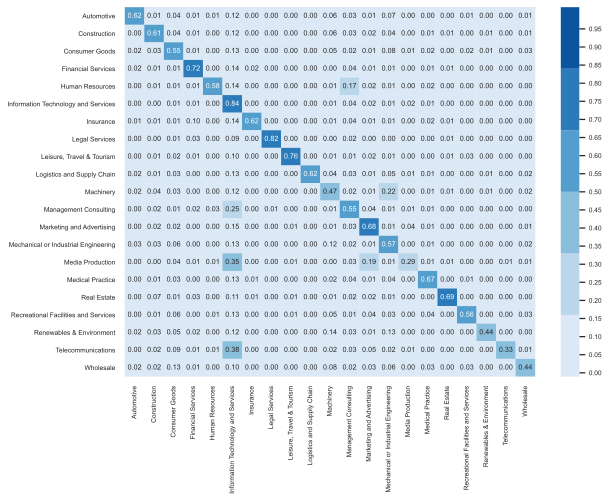

In [236]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(9, 7))
sns.set(font_scale=0.6)
sns.heatmap(all_svm_cm, 
            annot=True, 
            cmap=sns.color_palette("Blues"),
            vmin=-0.01,
            vmax=1.01,
            cbar_kws=dict(ticks=np.arange(0.0, 1.0, 0.05)),
            fmt='.2f')
plt.tight_layout()
#plt.savefig(f"../results/text/{SUB_DIR}_all_svm_cm.png", dpi=300, facecolor="white", transparent=False)
plt.show()

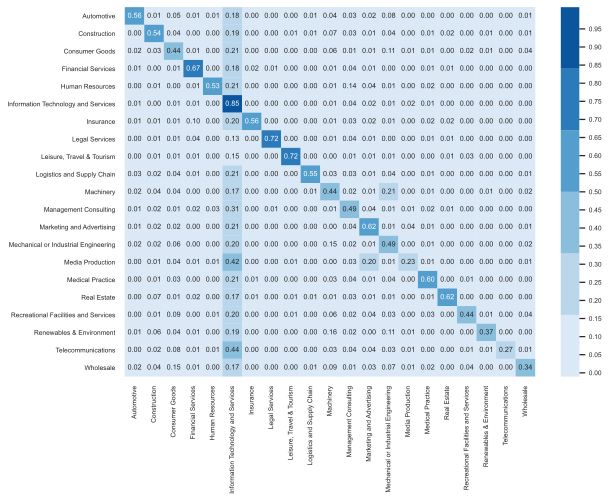

In [235]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(9, 7))
sns.set(font_scale=0.6)
sns.heatmap(all_xgb_tree_cm, 
            annot=True, 
            cmap=sns.color_palette("Blues"),
            vmin=-0.01,
            vmax=1.01,
            cbar_kws=dict(ticks=np.arange(0.0, 1.0, 0.05)),
            fmt='.2f')
plt.title("")
plt.tight_layout()
plt.show()